# Data Science Bowl 2019

# Introduction

PBS KIDS, a trusted name in early childhood education for decades, aims to gain insights into how media can help children learn important skills for success in school and life. In this challenge, you’ll use anonymous gameplay data, including knowledge of videos watched and games played, from the PBS KIDS Measure Up! app, a game-based learning tool developed as a part of the CPB-PBS Ready To Learn Initiative with funding from the U.S. Department of Education. Competitors will be challenged to predict scores on in-game assessments and create an algorithm that will lead to better-designed games and improved learning outcomes. Your solutions will aid in discovering important relationships between engagement with high-quality educational media and learning processes.

**Where does the data for the competition come from?**
The data used in this competition is anonymous, tabular data of interactions with the PBS KIDS Measure Up! app. Select data, such as a user’s in-app assessment score or their path through the game, is collected by the PBS KIDS Measure Up! app, a game-based learning tool.

**What is the PBS KIDS Measure Up! app?**
In the PBS KIDS Measure Up! app, children ages 3 to 5 learn early STEM concepts focused on length, width, capacity, and weight while going on an adventure through Treetop City, Magma Peak, and Crystal Caves. Joined by their favorite PBS KIDS characters, children can also collect rewards and unlock digital toys as they play. 

Besides the info provided above by Kaggle, I found the following additional info on the website of the app:

Specific features of Measure Up! include:

* 19 unique measuring games.
* 10 measurement-focused video clips.
* Sticker books featuring favorite PBS KIDS characters.
* Rewards for completion of tasks.
* Embedded challenges and reports to help parents and caregivers monitor kids’ progress.
* Ability to track your child's progress using the PBS KIDS Super Vision companion app.

**Evaluation**
Submissions are scored based on the quadratic weighted kappa, which measures the agreement between two outcomes. This metric typically varies from 0 (random agreement) to 1 (complete agreement). In the event that there is less agreement than expected by chance, the metric may go below 0.

The outcomes in this competition are grouped into 4 groups (labeled accuracy_group in the data):

3: the assessment was solved on the first attempt

2: the assessment was solved on the second attempt

1: the assessment was solved after 3 or more attempts

0: the assessment was never solved



For each installation_id represented in the test set, you must predict the accuracy_group of the last assessment for that installation_id.

Note that the training set contains many installation_ids which never took assessments, whereas every installation_id in the test set made an attempt on at least one assessment.

The file train_labels.csv has been provided to show how these groups would be computed on the assessments in the training set. Assessment attempts are captured in event_code 4100 for all assessments except for Bird Measurer, which uses event_code 4110. If the attempt was correct, it contains "correct":true.

# Table of contents

* [1. Understanding the train data](#1.-Understanding-the-train-data)
* [2. Understanding the test set](#2.-Understanding-the-test-set)
* [3. Understanding and visualizing the train labels](#3.-Understanding-and-visualizing-the train-labels)
* [4. Feature engineering and visualizations](#4.-Feature-engineering-and-visualizations)

In [1]:
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np
import seaborn as sns
import matplotlib.style as style
style.use('fivethirtyeight')
import matplotlib.pylab as plt
import calendar
import warnings
warnings.filterwarnings("ignore")

In [36]:
import json
from pandas.io.json import json_normalize

In [6]:
train = pd.read_csv('data/raw/data-science-bowl-2019/train.csv')


In [7]:
train_labels = pd.read_csv('data/raw/data-science-bowl-2019/train_labels.csv')

In [78]:
test = pd.read_csv('data/raw/data-science-bowl-2019/test.csv')

In [8]:
specs = pd.read_csv('data/raw/data-science-bowl-2019/specs.csv')


In [130]:
sample_sub = pd.read_csv('data/raw/data-science-bowl-2019/sample_submission.csv')

In [131]:
sample_sub.head()

,installation_id,accuracy_group
0,00abaee7,3
1,01242218,3
2,017c5718,3
3,01a44906,3
4,01bc6cb6,3


# 1. Understanding the train data

In [10]:
train.head()

,event_id,game_session,timestamp,event_data,installation_id,event_count,event_code,game_time,title,type,world
0,27253bdc,45bb1e1b6b50c07b,2019-09-06T17:53:46.937Z,"{""event_code"": 2000, ""event_count"": 1}",0001e90f,1,2000,0,Welcome to Lost Lagoon!,Clip,NONE
1,27253bdc,17eeb7f223665f53,2019-09-06T17:54:17.519Z,"{""event_code"": 2000, ""event_count"": 1}",0001e90f,1,2000,0,Magma Peak - Level 1,Clip,MAGMAPEAK
2,77261ab5,0848ef14a8dc6892,2019-09-06T17:54:56.302Z,"{""version"":""1.0"",""event_count"":1,""game_time"":0...",0001e90f,1,2000,0,Sandcastle Builder (Activity),Activity,MAGMAPEAK
3,b2dba42b,0848ef14a8dc6892,2019-09-06T17:54:56.387Z,"{""description"":""Let's build a sandcastle! Firs...",0001e90f,2,3010,53,Sandcastle Builder (Activity),Activity,MAGMAPEAK
4,1bb5fbdb,0848ef14a8dc6892,2019-09-06T17:55:03.253Z,"{""description"":""Let's build a sandcastle! Firs...",0001e90f,3,3110,6972,Sandcastle Builder (Activity),Activity,MAGMAPEAK


In [11]:
train.shape

(11341042, 11)

So we have 11 million rows and just 11 columns. However, Kaggle provided the following note: Note that the training set contains many installation_ids which never took assessments, whereas every installation_id in the test set made an attempt on at least one assessment.

As there is no point in keeping training data that cannot be used for training anyway, I am getting rid of the installation_ids that never took an assessment
    

In [16]:
keep_id = train[train.type == "Assessment"][['installation_id']].drop_duplicates()
train = pd.merge(train, keep_id, on="installation_id", how="inner")

As you can see, we have now lost about 3 million rows.

In [17]:
train.shape

(8294138, 11)

The number of unique installations in our "smaller" train set is now 4242.

In [18]:
keep_id.shape

(4242, 1)

I will first visualize some of the existing columns.

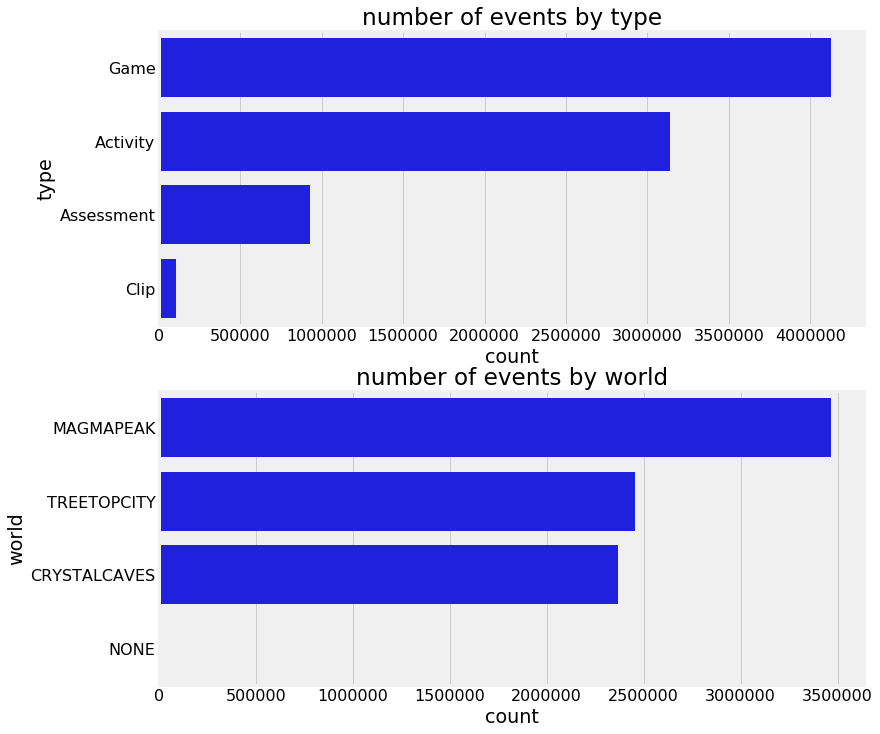

In [19]:
plt.rcParams.update({'font.size': 16})

fig = plt.figure(figsize=(12,10))
ax1 = fig.add_subplot(211)
ax1 = sns.countplot(y="type", data=train, color="blue", order = train.type.value_counts().index)
plt.title("number of events by type")

ax2 = fig.add_subplot(212)
ax2 = sns.countplot(y="world", data=train, color="blue", order = train.world.value_counts().index)
plt.title("number of events by world")

plt.tight_layout(pad=0)
plt.show()

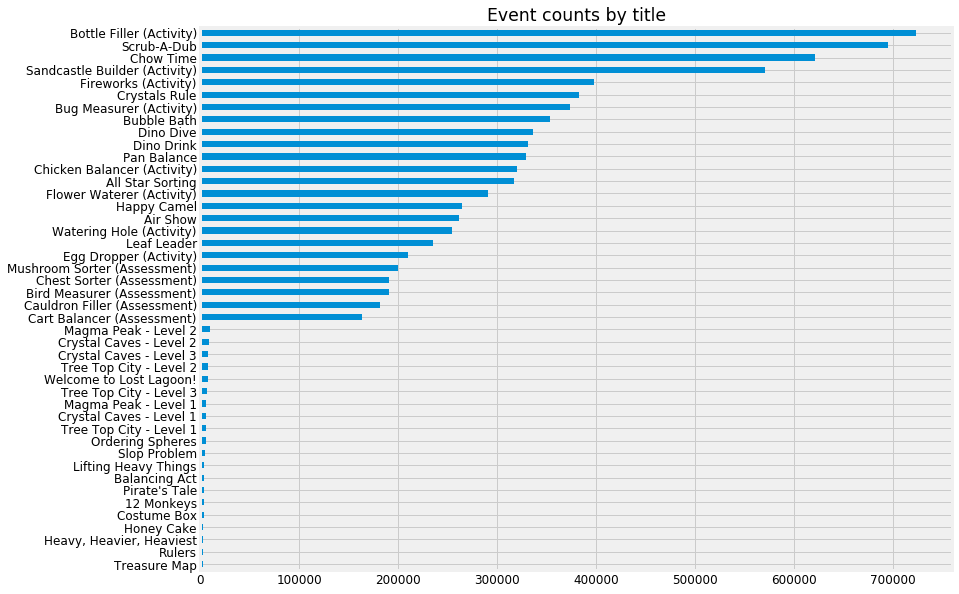

In [20]:
plt.rcParams.update({'font.size': 12})

fig = plt.figure(figsize=(12,10))
se = train.title.value_counts().sort_values(ascending=True)
se.plot.barh()
plt.title("Event counts by title")
plt.xticks(rotation=0)
plt.show()

I will now add some new columns based on the timestamp, and visualize these.

In [21]:
def get_time(df):
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df['date'] = df['timestamp'].dt.date
    df['month'] = df['timestamp'].dt.month
    df['hour'] = df['timestamp'].dt.hour
    df['dayofweek'] = df['timestamp'].dt.dayofweek
    return df
    
train = get_time(train)

Below your see the counts by date. By the way, I have wasted a lot of time on trying to fix the weird ticks on the x-axis, but this seems a bug: https://github.com/matplotlib/matplotlib/issues/13183

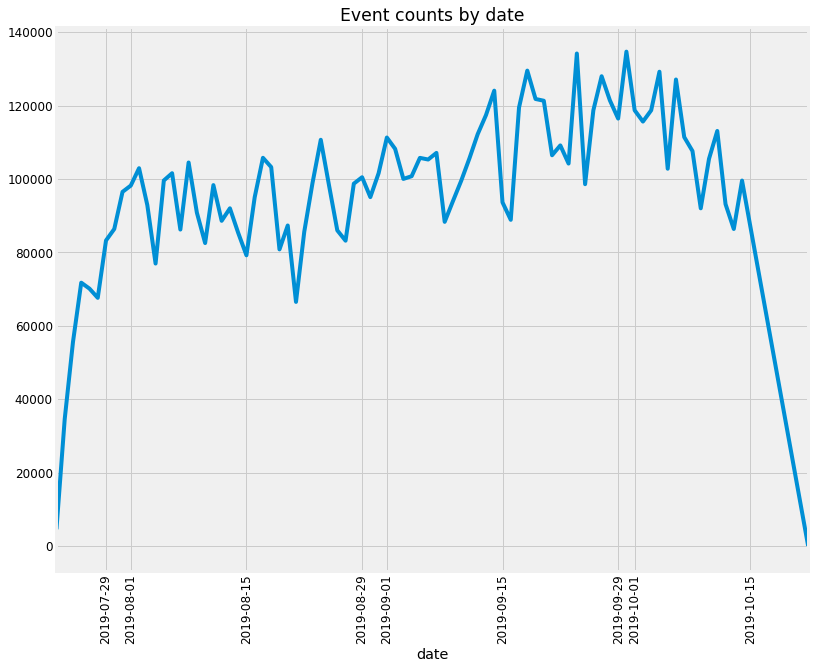

In [22]:
fig = plt.figure(figsize=(12,10))
se = train.groupby('date')['date'].count()
se.plot()
plt.title("Event counts by date")
plt.xticks(rotation=90)
plt.show()

When looking at the day of the week, we see no major difference. Of course, we are talking about kids who don't have to go to work ;-)

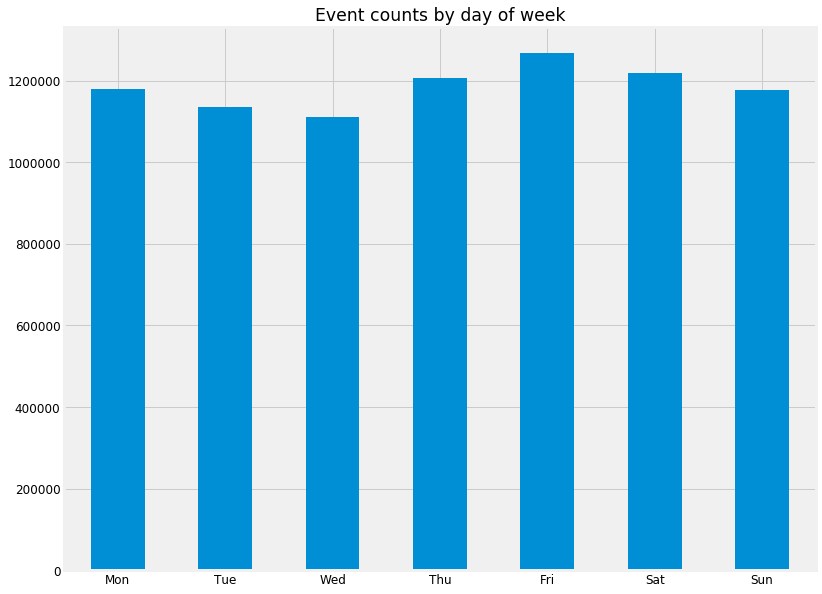

In [23]:
fig = plt.figure(figsize=(12,10))
se = train.groupby('dayofweek')['dayofweek'].count()
se.index = list(calendar.day_abbr)
se.plot.bar()
plt.title("Event counts by day of week")
plt.xticks(rotation=0)
plt.show()

When looking at the numbers by hour of the day, I find the distribution a little bit strange. Kids seem up late at night and don't do much early in the morning. Has this something to do with time zones perhaps?

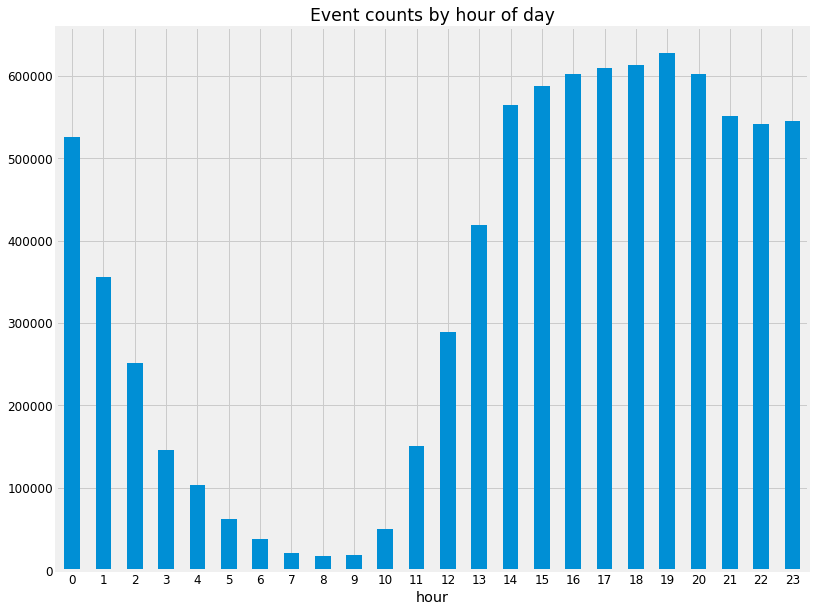

In [24]:
fig = plt.figure(figsize=(12,10))
se = train.groupby('hour')['hour'].count()
se.plot.bar()
plt.title("Event counts by hour of day")
plt.xticks(rotation=0)
plt.show()

# 2. Understanding the test set

From Kaggle: For each installation_id represented in the test set, you must predict the accuracy_group of the last assessment for that installation_id.

In [30]:
test.head()

,event_id,game_session,timestamp,event_data,installation_id,event_count,event_code,game_time,title,type,world
0,27253bdc,0ea9ecc81a565215,2019-09-10T16:50:24.910Z,"{""event_code"": 2000, ""event_count"": 1}",00abaee7,1,2000,0,Welcome to Lost Lagoon!,Clip,NONE
1,27253bdc,c1ea43d8b8261d27,2019-09-10T16:50:55.503Z,"{""event_code"": 2000, ""event_count"": 1}",00abaee7,1,2000,0,Magma Peak - Level 1,Clip,MAGMAPEAK
2,27253bdc,7ed86c6b72e725e2,2019-09-10T16:51:51.805Z,"{""event_code"": 2000, ""event_count"": 1}",00abaee7,1,2000,0,Magma Peak - Level 2,Clip,MAGMAPEAK
3,27253bdc,7e516ace50e7fe67,2019-09-10T16:53:12.825Z,"{""event_code"": 2000, ""event_count"": 1}",00abaee7,1,2000,0,Crystal Caves - Level 1,Clip,CRYSTALCAVES
4,7d093bf9,a022c3f60ba547e7,2019-09-10T16:54:12.115Z,"{""version"":""1.0"",""round"":0,""event_count"":1,""ga...",00abaee7,1,2000,0,Chow Time,Game,CRYSTALCAVES


In [31]:
test.shape

(1156414, 11)

In [32]:
test.installation_id.nunique()

1000

So we have 1.1 million rows on a thousand unique installation_ids in the test set. Below, you can see that we have this same amount of rows in the sample submission. This means that there are no installation_ids without assessment in the test set indeed.

In [33]:
sample_sub.shape

(1000, 2)

In [34]:
train[train.installation_id.isin(test.installation_id.unique())].installation_id.nunique()

0

In [35]:
train[train.installation_id.isin(test.installation_id.unique()) != True].installation_id.nunique()

4242

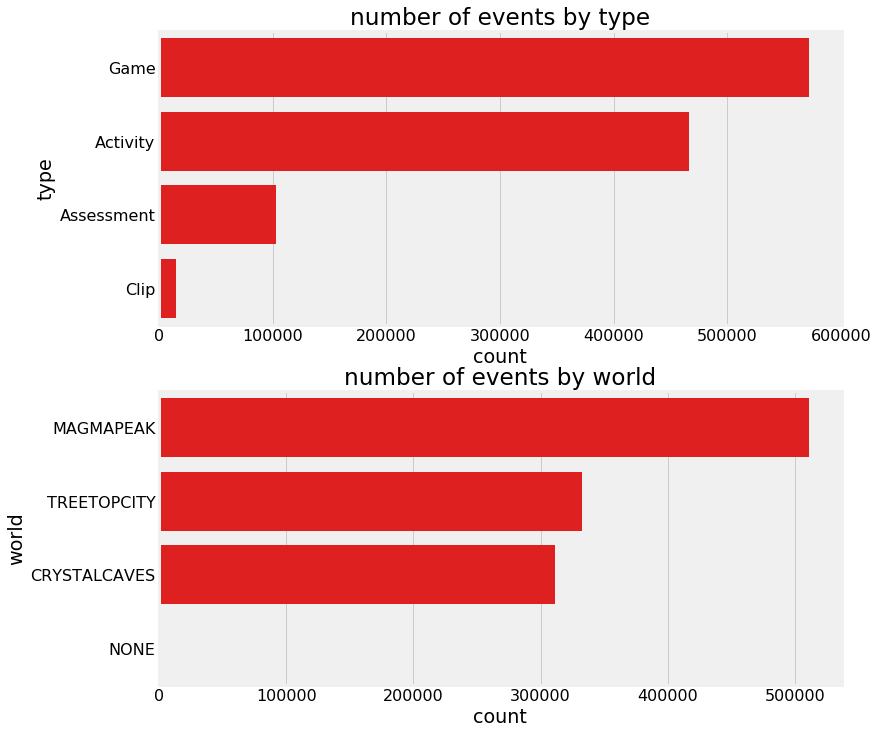

In [85]:
plt.rcParams.update({'font.size': 16})

fig = plt.figure(figsize=(12,10))
ax1 = fig.add_subplot(211)
ax1 = sns.countplot(y="type", data=test, color="red", order = test.type.value_counts().index)
plt.title("number of events by type")

ax2 = fig.add_subplot(212)
ax2 = sns.countplot(y="world", data=test, color="red", order = test.world.value_counts().index)
plt.title("number of events by world")

plt.tight_layout(pad=0)
plt.show()

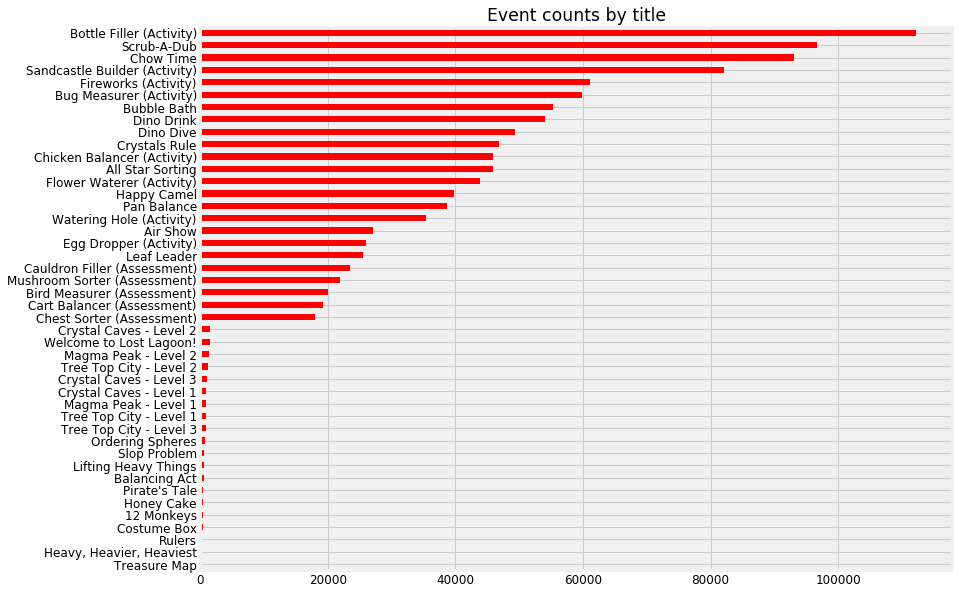

In [89]:
plt.rcParams.update({'font.size': 12})

fig = plt.figure(figsize=(12,10))
se = test.title.value_counts().sort_values(ascending=True)
se.plot.barh(color='red')
plt.title("Event counts by title")
plt.xticks(rotation=0)
plt.show()

I will now add some new columns based on the timestamp, and visualize these.

In [81]:
test = get_time(test)

Below your see the counts by date. By the way, I have wasted a lot of time on trying to fix the weird ticks on the x-axis, but this seems a bug: https://github.com/matplotlib/matplotlib/issues/13183

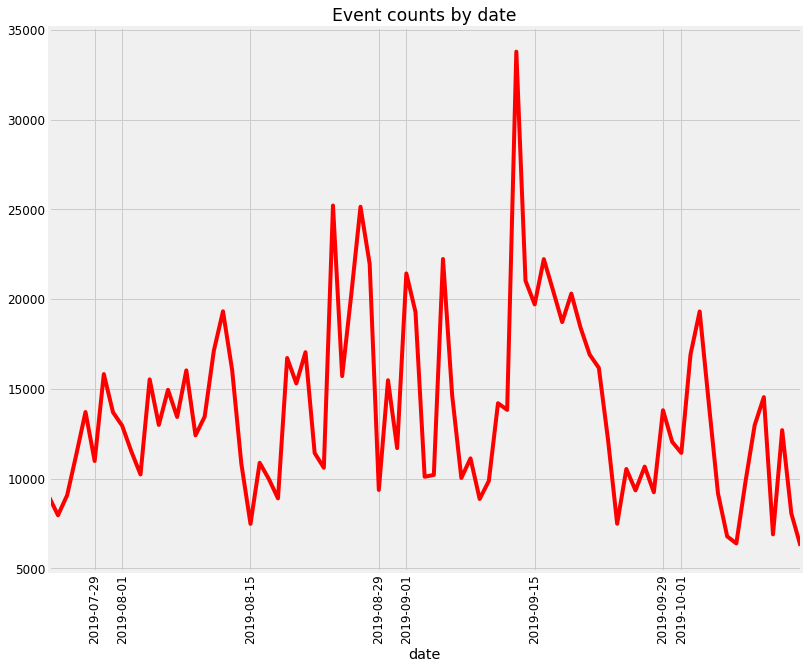

In [90]:
fig = plt.figure(figsize=(12,10))
se = test.groupby('date')['date'].count()
se.plot(color='red')
plt.title("Event counts by date")
plt.xticks(rotation=90)
plt.show()

When looking at the day of the week, we see no major difference. Of course, we are talking about kids who don't have to go to work ;-)

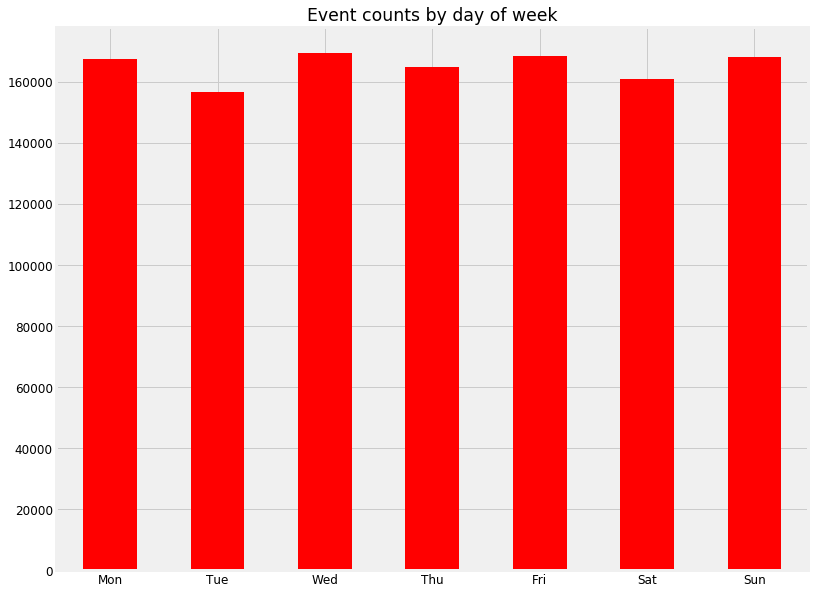

In [91]:
fig = plt.figure(figsize=(12,10))
se = test.groupby('dayofweek')['dayofweek'].count()
se.index = list(calendar.day_abbr)
se.plot.bar(color='red')
plt.title("Event counts by day of week")
plt.xticks(rotation=0)
plt.show()

When looking at the numbers by hour of the day, I find the distribution a little bit strange. Kids seem up late at night and don't do much early in the morning. Has this something to do with time zones perhaps?

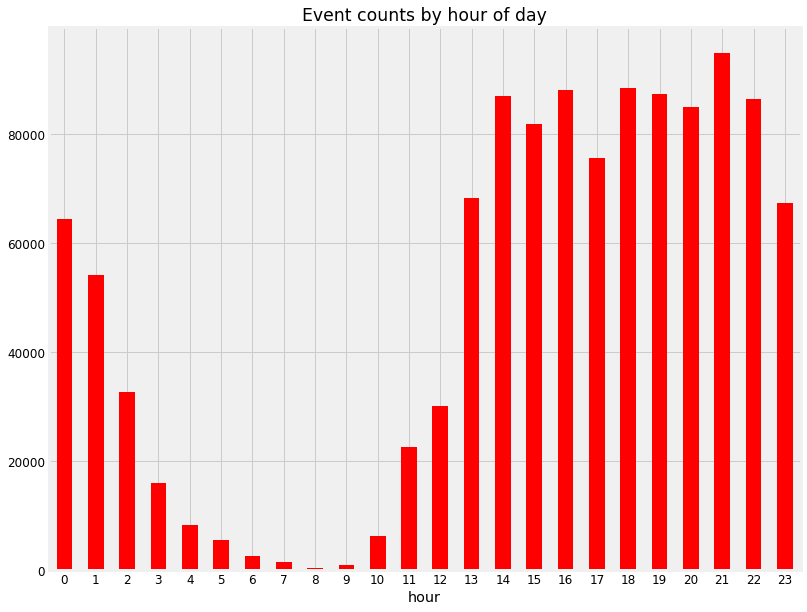

In [92]:
fig = plt.figure(figsize=(12,10))
se = test.groupby('hour')['hour'].count()
se.plot.bar(color='red')
plt.title("Event counts by hour of day")
plt.xticks(rotation=0)
plt.show()

# 3. Understanding and visualizing the train labels

The outcomes in this competition are grouped into 4 groups (labeled accuracy_group in the data):

3: the assessment was solved on the first attempt

2: the assessment was solved on the second attempt

1: the assessment was solved after 3 or more attempts

0: the assessment was never solved


I started by visualizing some of these columns

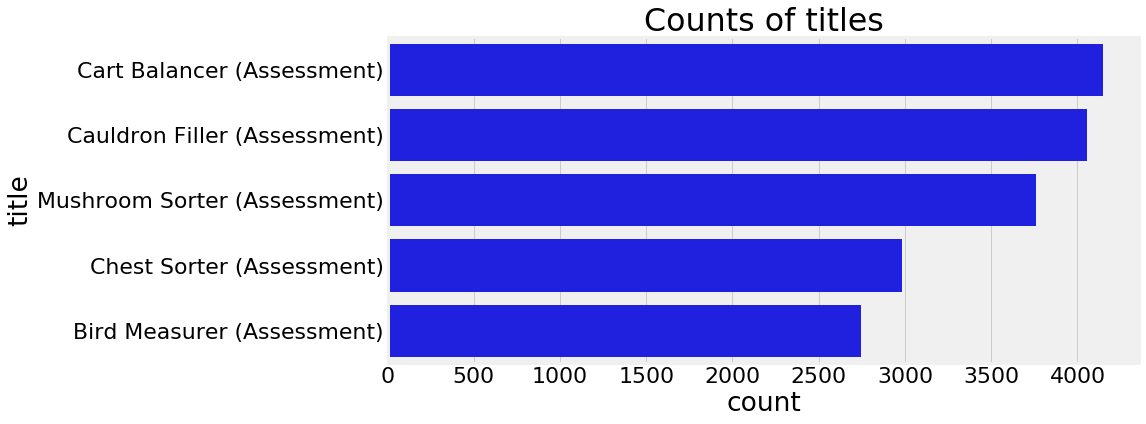

In [36]:
plt.rcParams.update({'font.size': 22})

plt.figure(figsize=(12,6))
sns.countplot(y="title", data=train_labels, color="blue", order = train_labels.title.value_counts().index)
plt.title("Counts of titles")
plt.show()

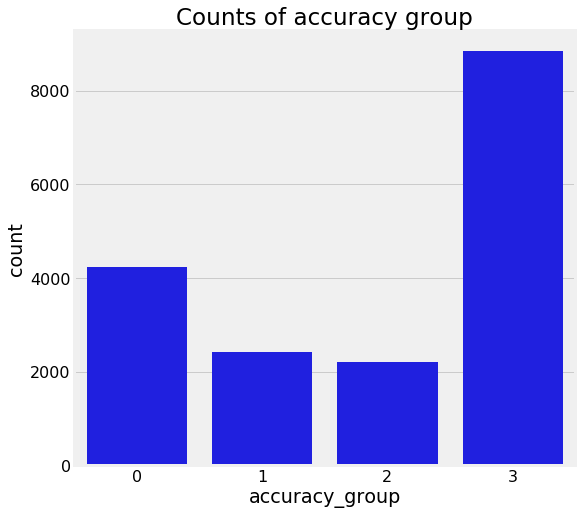

In [37]:
plt.rcParams.update({'font.size': 16})

plt.figure(figsize=(8,8))
sns.countplot(x="accuracy_group", data=train_labels, color="blue")
plt.title("Counts of accuracy group")
plt.show()

As the match between the train dataframe and the train_labels dataframe is not straightforward, it tried to figure out how these dataframes are to be matched by focussing on just one particular installation_id.

In [38]:
train_labels[train_labels.installation_id == "0006a69f"]

,game_session,installation_id,title,num_correct,num_incorrect,accuracy,accuracy_group
0,6bdf9623adc94d89,0006a69f,Mushroom Sorter (Assessment),1,0,1.0,3
1,77b8ee947eb84b4e,0006a69f,Bird Measurer (Assessment),0,11,0.0,0
2,901acc108f55a5a1,0006a69f,Mushroom Sorter (Assessment),1,0,1.0,3
3,9501794defd84e4d,0006a69f,Mushroom Sorter (Assessment),1,1,0.5,2
4,a9ef3ecb3d1acc6a,0006a69f,Bird Measurer (Assessment),1,0,1.0,3


In [48]:
train[(train.installation_id == "0006a69f") & (train.game_session == "6bdf9623adc94d89") & (train.event_code == 4100)]

,event_id,game_session,timestamp,event_data,installation_id,event_count,event_code,game_time,title,type,world,date,month,hour,dayofweek,attempt,correct
1259,25fa8af4,6bdf9623adc94d89,2019-08-06 05:38:08.036000+00:00,"{""correct"":true,""stumps"":[1,2,4],""event_count""...",0006a69f,30,4100,18026,Mushroom Sorter (Assessment),Assessment,TREETOPCITY,2019-08-06,8,5,1,1,True


In [49]:
train[(train.installation_id == "0006a69f") & (train.game_session == "901acc108f55a5a1") & (train.event_code == 4100)]

,event_id,game_session,timestamp,event_data,installation_id,event_count,event_code,game_time,title,type,world,date,month,hour,dayofweek,attempt,correct
690,25fa8af4,901acc108f55a5a1,2019-08-06 05:22:32.357000+00:00,"{""correct"":true,""stumps"":[1,2,4],""event_count""...",0006a69f,44,4100,31011,Mushroom Sorter (Assessment),Assessment,TREETOPCITY,2019-08-06,8,5,1,1,True


In [41]:
train[train.event_code == 4110]

,event_id,game_session,timestamp,event_data,installation_id,event_count,event_code,game_time,title,type,world,date,month,hour,dayofweek
737,dcb55a27,80d34a30c2998653,2019-08-06 05:24:05.811000+00:00,"{""distance"":8,""round"":0,""event_count"":43,""game...",0006a69f,43,4110,69853,Air Show,Game,TREETOPCITY,2019-08-06,8,5,1
750,dcb55a27,80d34a30c2998653,2019-08-06 05:24:24.726000+00:00,"{""distance"":10,""round"":0,""event_count"":56,""gam...",0006a69f,56,4110,88771,Air Show,Game,TREETOPCITY,2019-08-06,8,5,1
1171,17113b36,77b8ee947eb84b4e,2019-08-06 05:35:54.898000+00:00,"{""correct"":false,""caterpillars"":[11,8,3],""even...",0006a69f,29,4110,35771,Bird Measurer (Assessment),Assessment,TREETOPCITY,2019-08-06,8,5,1
1177,17113b36,77b8ee947eb84b4e,2019-08-06 05:36:01.927000+00:00,"{""correct"":false,""caterpillars"":[11,8,11],""eve...",0006a69f,35,4110,42805,Bird Measurer (Assessment),Assessment,TREETOPCITY,2019-08-06,8,5,1
1182,17113b36,77b8ee947eb84b4e,2019-08-06 05:36:06.512000+00:00,"{""correct"":false,""caterpillars"":[11,8,5],""even...",0006a69f,40,4110,47388,Bird Measurer (Assessment),Assessment,TREETOPCITY,2019-08-06,8,5,1
1187,17113b36,77b8ee947eb84b4e,2019-08-06 05:36:09.739000+00:00,"{""correct"":false,""caterpillars"":[11,8,7],""even...",0006a69f,45,4110,50605,Bird Measurer (Assessment),Assessment,TREETOPCITY,2019-08-06,8,5,1
1192,17113b36,77b8ee947eb84b4e,2019-08-06 05:36:13.951000+00:00,"{""correct"":false,""caterpillars"":[11,8,4],""even...",0006a69f,50,4110,54822,Bird Measurer (Assessment),Assessment,TREETOPCITY,2019-08-06,8,5,1
1195,17113b36,77b8ee947eb84b4e,2019-08-06 05:36:17.407000+00:00,"{""correct"":false,""caterpillars"":[11,8,4],""even...",0006a69f,53,4110,58280,Bird Measurer (Assessment),Assessment,TREETOPCITY,2019-08-06,8,5,1
1200,17113b36,77b8ee947eb84b4e,2019-08-06 05:36:21.390000+00:00,"{""correct"":false,""caterpillars"":[11,8,2],""even...",0006a69f,58,4110,62256,Bird Measurer (Assessment),Assessment,TREETOPCITY,2019-08-06,8,5,1
1205,17113b36,77b8ee947eb84b4e,2019-08-06 05:36:26.296000+00:00,"{""correct"":false,""caterpillars"":[11,8,1],""even...",0006a69f,63,4110,67164,Bird Measurer (Assessment),Assessment,TREETOPCITY,2019-08-06,8,5,1


From Kaggle: The file train_labels.csv has been provided to show how these groups would be computed on the assessments in the training set. Assessment attempts are captured in event_code 4100 for all assessments except for Bird Measurer, which uses event_code 4110. If the attempt was correct, it contains "correct":true.

However, in the first version I already noticed that I had one attempt too many for this installation_id when mapping the rows with the train_labels for. It turns out that there are in fact also assessment attemps for Bird Measurer with event_code 4100, which should not count (see below). In this case that also makes sense as this installation_id already had a pass on the first attempt

In [44]:
train[(train.event_code == 4100) & (train.installation_id == "0006a69f") & (train.title == "Bird Measurer (Assessment)")]

,event_id,game_session,timestamp,event_data,installation_id,event_count,event_code,game_time,title,type,world,date,month,hour,dayofweek
2615,070a5291,a9ef3ecb3d1acc6a,2019-08-06 20:50:33.283000+00:00,"{""correct"":true,""hats"":[4,8,5],""event_count"":3...",0006a69f,30,4100,34209,Bird Measurer (Assessment),Assessment,TREETOPCITY,2019-08-06,8,20,1


After having read Andrew Lukyanenko's notebook, I decided to also create an attempt variable. In addition, I have also borrowed his code to extract the correct variable (thanks Andrew!).

In [46]:
#credits for this code chuck go to Andrew Lukyanenko
train['attempt'] = 0
train.loc[(train['title'] == 'Bird Measurer (Assessment)') & (train['event_code'] == 4110),\
       'attempt'] = 1
train.loc[(train['type'] == 'Assessment') &\
       (train['title'] != 'Bird Measurer (Assessment)')\
       & (train['event_code'] == 4100),\
          'attempt'] = 1

train['correct'] = None
train.loc[(train['attempt'] == 1) & (train['event_data'].str.contains('"correct":true')), 'correct'] = True
train.loc[(train['attempt'] == 1) & (train['event_data'].str.contains('"correct":false')), 'correct'] = False

Below you can see that row 2615 is not in the assessment results of this installation_id anymore, and the results add up nicely to the num_correct and num_incorrect in the train_labels.

In [47]:
train[(train.installation_id == "0006a69f") & (train.attempt == 1)]

,event_id,game_session,timestamp,event_data,installation_id,event_count,event_code,game_time,title,type,world,date,month,hour,dayofweek,attempt,correct
690,25fa8af4,901acc108f55a5a1,2019-08-06 05:22:32.357000+00:00,"{""correct"":true,""stumps"":[1,2,4],""event_count""...",0006a69f,44,4100,31011,Mushroom Sorter (Assessment),Assessment,TREETOPCITY,2019-08-06,8,5,1,1,True
1171,17113b36,77b8ee947eb84b4e,2019-08-06 05:35:54.898000+00:00,"{""correct"":false,""caterpillars"":[11,8,3],""even...",0006a69f,29,4110,35771,Bird Measurer (Assessment),Assessment,TREETOPCITY,2019-08-06,8,5,1,1,False
1177,17113b36,77b8ee947eb84b4e,2019-08-06 05:36:01.927000+00:00,"{""correct"":false,""caterpillars"":[11,8,11],""eve...",0006a69f,35,4110,42805,Bird Measurer (Assessment),Assessment,TREETOPCITY,2019-08-06,8,5,1,1,False
1182,17113b36,77b8ee947eb84b4e,2019-08-06 05:36:06.512000+00:00,"{""correct"":false,""caterpillars"":[11,8,5],""even...",0006a69f,40,4110,47388,Bird Measurer (Assessment),Assessment,TREETOPCITY,2019-08-06,8,5,1,1,False
1187,17113b36,77b8ee947eb84b4e,2019-08-06 05:36:09.739000+00:00,"{""correct"":false,""caterpillars"":[11,8,7],""even...",0006a69f,45,4110,50605,Bird Measurer (Assessment),Assessment,TREETOPCITY,2019-08-06,8,5,1,1,False
1192,17113b36,77b8ee947eb84b4e,2019-08-06 05:36:13.951000+00:00,"{""correct"":false,""caterpillars"":[11,8,4],""even...",0006a69f,50,4110,54822,Bird Measurer (Assessment),Assessment,TREETOPCITY,2019-08-06,8,5,1,1,False
1195,17113b36,77b8ee947eb84b4e,2019-08-06 05:36:17.407000+00:00,"{""correct"":false,""caterpillars"":[11,8,4],""even...",0006a69f,53,4110,58280,Bird Measurer (Assessment),Assessment,TREETOPCITY,2019-08-06,8,5,1,1,False
1200,17113b36,77b8ee947eb84b4e,2019-08-06 05:36:21.390000+00:00,"{""correct"":false,""caterpillars"":[11,8,2],""even...",0006a69f,58,4110,62256,Bird Measurer (Assessment),Assessment,TREETOPCITY,2019-08-06,8,5,1,1,False
1205,17113b36,77b8ee947eb84b4e,2019-08-06 05:36:26.296000+00:00,"{""correct"":false,""caterpillars"":[11,8,1],""even...",0006a69f,63,4110,67164,Bird Measurer (Assessment),Assessment,TREETOPCITY,2019-08-06,8,5,1,1,False
1212,17113b36,77b8ee947eb84b4e,2019-08-06 05:36:32.187000+00:00,"{""correct"":false,""caterpillars"":[11,8,1],""even...",0006a69f,70,4110,73056,Bird Measurer (Assessment),Assessment,TREETOPCITY,2019-08-06,8,5,1,1,False


Now the question arises: Could there be installation_id's who did assessments (we have already taken out the ones who never took one), but without results in the train_labels? As you can see below, yes there are 628 of those.

In [50]:
train[~train.installation_id.isin(train_labels.installation_id.unique())].installation_id.nunique()

628

As we can not train on those installation_id's anyway, I am taking them out of the train set. This reduces our train set further from 8.3 million rows to 7.7 million.

In [51]:
train = train[train.installation_id.isin(train_labels.installation_id.unique())]
train.shape

(7734558, 17)

In [52]:
train.installation_id.nunique()

3614

# 4. Feature engineering; adding features to train_labels

Basically what we need to do is add features to the train_labels dataframe to get our training dataset. Before I get started, I am quickly checking if game_session alone is the unique identifier in train labels.

In [53]:
print(f'Number of rows in train_labels: {train_labels.shape[0]}')
print(f'Number of unique game_sessions in train_labels: {train_labels.game_session.nunique()}')

Number of rows in train_labels: 17690
Number of unique game_sessions in train_labels: 17690


Ok, now that we have that confirmed, I my first step was initially to start by looking for values that are always the same for a game_session in the train dataframe. It turns out that the only one is world. I also checked if some of the datetime variables were unique, but this is not always the case (events within a session may cross midnight).

Of course, on Kaggle it is not always necessary to reinvent the wheel. I knew that I would have to iterate over all the rows and add features that only look at what happened up to the moment at which the an installation_id starts a particluar assessment. I found out that Massoud Hosseinali already posted fantastic code on how to do that in this kernel: https://www.kaggle.com/mhviraf/a-new-baseline-for-dsb-2019-catboost-model. Thanks Massoud, and all credit go to you! As Bruno Aquino reused this code and already added some comments, I am actually using his code.

As I figured out that datetime variables cannot be matched uniquely to the train_labels, I am starting again with a train dataframe as it originally was (except for keeping timestamp as datetime). First step: encode the title

In [54]:
train = train.drop(['date', 'month', 'hour', 'dayofweek', 'attempt', 'correct'], axis=1)

#Credits go to Massoud Hosseinali

# encode title
# make a list with all the unique 'titles' from the train and test set
list_of_user_activities = list(set(train['title'].value_counts().index).union(set(test['title'].value_counts().index)))
# make a list with all the unique 'event_code' from the train and test set
list_of_event_code = list(set(train['event_code'].value_counts().index).union(set(test['event_code'].value_counts().index)))
# create a dictionary numerating the titles
activities_map = dict(zip(list_of_user_activities, np.arange(len(list_of_user_activities))))
#activities_labels = dict(zip(np.arange(len(list_of_user_activities)), list_of_user_activities))

In [56]:
# replace the text titles withing the number titles from the dict
train['title'] = train['title'].map(activities_map)
test['title'] = test['title'].map(activities_map)
train_labels['title'] = train_labels['title'].map(activities_map)

In [57]:
train.head()

,event_id,game_session,timestamp,event_data,installation_id,event_count,event_code,game_time,title,type,world
0,27253bdc,34ba1a28d02ba8ba,2019-08-06 04:57:18.904000+00:00,"{""event_code"": 2000, ""event_count"": 1}",0006a69f,1,2000,0,11,Clip,NONE
1,27253bdc,4b57c9a59474a1b9,2019-08-06 04:57:45.301000+00:00,"{""event_code"": 2000, ""event_count"": 1}",0006a69f,1,2000,0,3,Clip,MAGMAPEAK
2,77261ab5,2b9d5af79bcdb79f,2019-08-06 04:58:14.538000+00:00,"{""version"":""1.0"",""event_count"":1,""game_time"":0...",0006a69f,1,2000,0,18,Activity,MAGMAPEAK
3,b2dba42b,2b9d5af79bcdb79f,2019-08-06 04:58:14.615000+00:00,"{""description"":""Let's build a sandcastle! Firs...",0006a69f,2,3010,29,18,Activity,MAGMAPEAK
4,1325467d,2b9d5af79bcdb79f,2019-08-06 04:58:16.680000+00:00,"{""coordinates"":{""x"":273,""y"":650,""stage_width"":...",0006a69f,3,4070,2137,18,Activity,MAGMAPEAK


In [58]:
train_labels.head()

,game_session,installation_id,title,num_correct,num_incorrect,accuracy,accuracy_group
0,6bdf9623adc94d89,0006a69f,32,1,0,1.0,3
1,77b8ee947eb84b4e,0006a69f,41,0,11,0.0,0
2,901acc108f55a5a1,0006a69f,32,1,0,1.0,3
3,9501794defd84e4d,0006a69f,32,1,1,0.5,2
4,a9ef3ecb3d1acc6a,0006a69f,41,1,0,1.0,3


## Train Event data

In [67]:
onesesion = train[train.game_session == '6bdf9623adc94d89'].copy()

In [69]:
event_data = []
for ev in onesesion.event_data:
    event_data.append(json.loads(ev))
    #print(ev)

In [71]:
event_data = pd.DataFrame(event_data)

In [75]:
event_data.index = onesesion.index.tolist()

In [73]:
event_data.columns = [c + '_evdata' for c in event_data.columns] 

In [93]:
onesesion = onesesion.join(event_data)

In [104]:
onesesion[onesesion.event_code == 4100]

,event_id,game_session,timestamp,event_data,installation_id,event_count,event_code,game_time,title,type,world,coordinates_evdata,correct_evdata,description_evdata,destination_evdata,duration_evdata,event_code_evdata,event_count_evdata,exit_type_evdata,game_time_evdata,height_evdata,identifier_evdata,media_type_evdata,misses_evdata,session_duration_evdata,source_evdata,stumps_evdata,total_duration_evdata,version_evdata
2797,25fa8af4,6bdf9623adc94d89,2019-08-06T05:38:08.036Z,"{""correct"":true,""stumps"":[1,2,4],""event_count""...",0006a69f,30,4100,18026,Mushroom Sorter (Assessment),Assessment,TREETOPCITY,NaN,True,NaN,NaN,NaN,4100,30,NaN,18026,NaN,NaN,NaN,NaN,NaN,NaN,"[1, 2, 4]",NaN,NaN


In [107]:
onesesion.to_csv('onesesion.csv', sep=';')

In [101]:
coordata = []
for ev in onesesion[onesesion.event_id == '7da34a02'].event_data:
    coordata.append(json.loads(ev))
    

In [102]:
coordata

[{'coordinates': {'x': 199,
   'y': 484,
   'stage_width': 1015,
   'stage_height': 762},
  'event_count': 4,
  'game_time': 2784,
  'event_code': 4070},
 {'coordinates': {'x': 323,
   'y': 534,
   'stage_width': 1015,
   'stage_height': 762},
  'event_count': 18,
  'game_time': 8876,
  'event_code': 4070},
 {'coordinates': {'x': 333,
   'y': 551,
   'stage_width': 1015,
   'stage_height': 762},
  'event_count': 19,
  'game_time': 9742,
  'event_code': 4070},
 {'coordinates': {'x': 328,
   'y': 534,
   'stage_width': 1015,
   'stage_height': 762},
  'event_count': 20,
  'game_time': 10692,
  'event_code': 4070},
 {'coordinates': {'x': 290,
   'y': 536,
   'stage_width': 1015,
   'stage_height': 762},
  'event_count': 22,
  'game_time': 11601,
  'event_code': 4070}]

## Test Event data

In [121]:
test[test.title == 'Mushroom Sorter (Assessment)']

,event_id,game_session,timestamp,event_data,installation_id,event_count,event_code,game_time,title,type,world,date,month,hour,dayofweek
2957,3bfd1a65,31423dbcd717919e,2019-09-22 22:14:10.921000+00:00,"{""version"":""1.0"",""event_count"":1,""game_time"":0...",01242218,1,2000,0,Mushroom Sorter (Assessment),Assessment,TREETOPCITY,2019-09-22,9,22,6
2958,db02c830,31423dbcd717919e,2019-09-22 22:14:11.016000+00:00,"{""event_count"":2,""game_time"":91,""event_code"":2...",01242218,2,2025,91,Mushroom Sorter (Assessment),Assessment,TREETOPCITY,2019-09-22,9,22,6
2959,a1e4395d,31423dbcd717919e,2019-09-22 22:14:11.022000+00:00,"{""description"":""Pull three mushrooms out of th...",01242218,3,3010,91,Mushroom Sorter (Assessment),Assessment,TREETOPCITY,2019-09-22,9,22,6
2960,a52b92d5,31423dbcd717919e,2019-09-22 22:14:14.858000+00:00,"{""description"":""Pull three mushrooms out of th...",01242218,4,3110,3983,Mushroom Sorter (Assessment),Assessment,TREETOPCITY,2019-09-22,9,22,6
2961,a1e4395d,31423dbcd717919e,2019-09-22 22:14:14.861000+00:00,"{""description"":""To pick a mushroom, pull it ou...",01242218,5,3010,3983,Mushroom Sorter (Assessment),Assessment,TREETOPCITY,2019-09-22,9,22,6
2962,28ed704e,31423dbcd717919e,2019-09-22 22:14:14.953000+00:00,"{""height"":2,""coordinates"":{""x"":474,""y"":478,""st...",01242218,6,4025,4079,Mushroom Sorter (Assessment),Assessment,TREETOPCITY,2019-09-22,9,22,6
2963,a52b92d5,31423dbcd717919e,2019-09-22 22:14:14.954000+00:00,"{""description"":""To pick a mushroom, pull it ou...",01242218,7,3110,4079,Mushroom Sorter (Assessment),Assessment,TREETOPCITY,2019-09-22,9,22,6
2964,9d29771f,31423dbcd717919e,2019-09-22 22:14:14.957000+00:00,"{""description"":""That's one!"",""identifier"":""Dot...",01242218,8,3021,4079,Mushroom Sorter (Assessment),Assessment,TREETOPCITY,2019-09-22,9,22,6
2965,c74f40cd,31423dbcd717919e,2019-09-22 22:14:15.579000+00:00,"{""description"":""That's one!"",""identifier"":""Dot...",01242218,9,3121,4711,Mushroom Sorter (Assessment),Assessment,TREETOPCITY,2019-09-22,9,22,6
2966,7da34a02,31423dbcd717919e,2019-09-22 22:14:18.112000+00:00,"{""coordinates"":{""x"":333,""y"":683,""stage_width"":...",01242218,10,4070,7228,Mushroom Sorter (Assessment),Assessment,TREETOPCITY,2019-09-22,9,22,6


In [123]:
onesesion = test[test.game_session == '31423dbcd717919e'].copy()

In [124]:
event_data = []
for ev in onesesion.event_data:
    event_data.append(json.loads(ev))
    #print(ev)

In [125]:
event_data = pd.DataFrame(event_data)

In [126]:
event_data.index = onesesion.index.tolist()

In [127]:
event_data.columns = [c + '_evdata' for c in event_data.columns] 

In [128]:
onesesion = onesesion.join(event_data)

In [129]:
onesesion.to_csv('onesesion_test.csv', sep=';')

## Understanding Specs Data

In [12]:
specs.head()

,event_id,info,args
0,2b9272f4,The end of system-initiated feedback (Correct)...,"[{""name"":""game_time"",""type"":""int"",""info"":""mill..."
1,df4fe8b6,The end of system-initiated feedback (Incorrec...,"[{""name"":""game_time"",""type"":""int"",""info"":""mill..."
2,3babcb9b,The end of system-initiated instruction event ...,"[{""name"":""game_time"",""type"":""int"",""info"":""mill..."
3,7f0836bf,The end of system-initiated instruction event ...,"[{""name"":""game_time"",""type"":""int"",""info"":""mill..."
4,ab3136ba,The end of system-initiated instruction event ...,"[{""name"":""game_time"",""type"":""int"",""info"":""mill..."


In [13]:
specs.shape

(386, 3)

In [14]:
specs.dtypes

event_id    object
info        object
args        object
dtype: object

#### info
- it has a short technical description about the event
- only 168 elements are unique
- maybe we could extract some features from it using TF-IDF

In [19]:
specs.iloc[9,1]

'The system-initiated feedback (Incorrect) event occurs when the game starts delivering feedback to the player in response to an incorrect round attempt (pressing the go button with the incorrect answer). It contains information that describes the content of the instruction. These events are used to determine the effectiveness of the feedback. We can answer questions like, "did players who received feedback X do better than those who did not?"'

In [43]:
specs[specs.event_id == '25fa8af4']['info'].tolist()

['This event occurs when the player on the done button to submit a solution. It contains information about the mushrooms placed on the stumps and the correctness of the action. This event is used to calculate accuracy and to diagnose player strategies and understanding.']

In [44]:
specs[specs.event_id == '17113b36']['info'].tolist()

['This event occurs when the player on the done button to submit a solution. It contains information about the length of caterpillars dragged and the correctness of the action. This event is used to calculate accuracy and to diagnose player strategies and understanding.']

In [35]:
np.unique([i for i in specs.iloc[:,1]]).shape

(168,)

In [45]:
data = json.loads(specs.iloc[0,2])

In [47]:
data

[{'name': 'game_time',
  'type': 'int',
  'info': 'millisecond count since start of game'},
 {'name': 'round',
  'type': 'int',
  'info': 'number of the current round when the event takes place or 0 if no round'},
 {'name': 'level',
  'type': 'int',
  'info': 'number of the current level when the event takes place or 0 if no level'},
 {'name': 'description',
  'type': 'string',
  'info': 'the text or description of the instruction'},
 {'name': 'identifier',
  'type': 'string',
  'info': 'a unique identifier for this piece of instruction'},
 {'name': 'media_type',
  'type': 'string',
  'info': "the type of media that has just played:\n'audio' || 'animation' || 'other'"},
 {'name': 'duration',
  'type': 'int',
  'info': 'the duration of the media playback in milliseconds'},
 {'name': 'event_count', 'type': 'int', 'info': 'session event counter'},
 {'name': 'event_code', 'type': 'int', 'info': 'event class identifier'}]

In [53]:
pd.DataFrame(data)



,info,name,type
0,millisecond count since start of game,game_time,int
1,number of the current round when the event tak...,round,int
2,number of the current level when the event tak...,level,int
3,the text or description of the instruction,description,string
4,a unique identifier for this piece of instruction,identifier,string
5,the type of media that has just played:\n'audi...,media_type,string
6,the duration of the media playback in millisec...,duration,int
7,session event counter,event_count,int
8,event class identifier,event_code,int


In [133]:
train[train.installation_id == '0006a69f'].to_csv('oneuser.csv',sep=';')

In [137]:
user_sample = train[train.installation_id == '0006a69f']

In [135]:
user_stats = dict()

In [136]:
user_stats[]

{}

In [142]:
user_stats['installation_id'] = user_sample['installation_id'].unique()[0]
user_stats['world'] = user_sample['world'].unique()[0]
user_stats['timestamp'] = user_sample['timestamp'].unique()[0]

temp_dict = defaultdict(int)
another_temp_dict = {}
another_temp_dict['durations'] = []
another_temp_dict['all_durations'] = []
another_temp_dict['durations_with_attempts'] = []
another_temp_dict['mean_action_time'] = []

In [144]:
user_stats

{'installation_id': '0006a69f',
 'world': 'NONE',
 'timestamp': '2019-08-06T04:57:18.904Z'}